In [1]:
folder=''
zero_frac = 0.25
m_frac = 0.6
p_frac = 0.6
correction = 0.2
top_crop, bottom_crop, left_crop, right_crop = 60, 25, 0, 0
EPOCHS = 3

## Build Log

In [2]:
import pandas as pd
%matplotlib inline

In [ ]:
driving_log = pd.read_csv('data22/driving_log.csv', header=None, names=['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed'], usecols=['center', 'left', 'right', 'steering']) 
#driving_log.head()

In [ ]:
driving_log_back = pd.read_csv('data2back/driving_log.csv', header=None, names=['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed'], usecols=['center', 'left', 'right', 'steering']) 
#driving_log_back.head()

In [ ]:
driving_log_dark = pd.read_csv('data2_dark/driving_log.csv', header=None, names=['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed'], usecols=['center', 'left', 'right', 'steering']) 
#driving_log_dark.head()

In [ ]:
driving_log['steering'].describe()

In [ ]:
driving_log_back['steering'].describe()

In [ ]:
driving_log_dark['steering'].describe()

In [ ]:
_ = driving_log['steering'].hist(bins=51, figsize=(15,5))

In [ ]:
_ = driving_log_back['steering'].hist(bins=51, figsize=(15,5))

In [ ]:
_ = driving_log_dark['steering'].hist(bins=51, figsize=(15,5))

In [ ]:
driving_log = driving_log.append(driving_log_back).append(driving_log_dark)
#driving_log = driving_log.sample(frac=1).reset_index(drop=True)

In [ ]:
driving_log['steering'].describe()

In [ ]:
_ = driving_log['steering'].hist(bins=51, figsize=(15,5))

In [ ]:
def undersample(log, value, frac):
    log_nonvalue = log[log['steering']!=value]
    log_value = log[log['steering']==value].sample(frac=frac)
    log = log_value.append(log_nonvalue)
    log = log.reset_index(drop=True)
    return log

In [ ]:
driving_log = undersample(driving_log, 0, zero_frac)
driving_log = undersample(driving_log, -1, m_frac)
driving_log = undersample(driving_log, 1, p_frac)

In [ ]:
driving_log['steering'].describe()

In [ ]:
_ = driving_log['steering'].hist(bins=51, figsize=(15,5))

In [ ]:
def augment_left_right(driving_log, correction):
    log = pd.DataFrame({'image':driving_log['center']
                                .append(driving_log['left'])
                                .append(driving_log['right']),
                        'flip': 0,
                        'steering':driving_log['steering']
                                .append(driving_log['steering'] + correction)
                                .append(driving_log['steering'] - correction)})

    log = log[(log['steering']>=-1)&(log['steering']<=1)]
    return log

In [ ]:
log = augment_left_right(driving_log, correction)

In [ ]:
log['steering'].describe()

In [ ]:
_ = log['steering'].hist(bins=51, figsize=(15,5))

In [ ]:
log['steering'].describe()

In [ ]:
_ = log['steering'].hist(bins=101, figsize=(15,5))

In [ ]:
log = log.sample(frac=1).reset_index(drop=True)  #shuffle log DataFrame

## Build Training and Validation Data

In [3]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, BatchNormalization
from keras.layers.convolutional import Convolution2D

from sklearn.model_selection import train_test_split
import sklearn

%matplotlib inline

Using TensorFlow backend.


In [ ]:
log.head()

In [ ]:
train_log, validation_log = train_test_split(log, test_size=0.2)

train_log = train_log.reset_index(drop=True)
validation_log = validation_log.reset_index(drop=True)

In [ ]:
def preprocess(image):
    #image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)[:,:,1]
    #image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = image[:,:,0]
    image = image[:,:,None]
    
    return image

In [ ]:
def get_data(log):    
    images = []
    steerings = []
    
    for _, row in log.iterrows():
        filename = folder+row['image'].strip()
        image = preprocess(mpimg.imread(filename))
        
        if row['flip']==1:
            image = cv2.flip(image, 1)[:,:,None]
            #steering = -steering
            
        steering = row['steering']

        images.append(image)
        steerings.append(steering)

    X, y = np.array(images), np.array(steerings)
    X, y = sklearn.utils.shuffle(X, y)
    
    return X, y

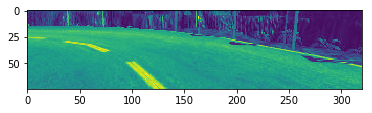

In [30]:
filename = "C:\\Users\ETASMAK\Documents\CarND-Behavioral-Cloning-P3\data22\IMG\left_2017_03_18_12_41_42_030.jpg"
#filename = "C:\\Users\ETASMAK\Documents\CarND-Behavioral-Cloning-P3\data22\IMG\center_2017_03_18_12_41_24_828.jpg"

image = mpimg.imread(filename)
#image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)[:,:,1]
image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)[:,:,0]
#image = image[:,:,2]

image = image[top_crop:-bottom_crop,:]
plt.imshow(image[:,:,None].squeeze())

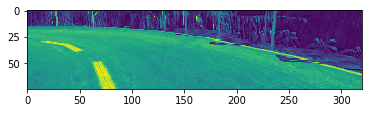

In [20]:
filename = "C:\\Users\ETASMAK\Documents\CarND-Behavioral-Cloning-P3\data22\IMG\center_2017_03_18_12_41_42_030.jpg"
#filename = "C:\\Users\ETASMAK\Documents\CarND-Behavioral-Cloning-P3\data22\IMG\center_2017_03_18_12_41_24_828.jpg"

image = mpimg.imread(filename)
#image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)[:,:,1]
#image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)[:,:,0]
image = image[:,:,2]

image = image[top_crop:-bottom_crop,:]
plt.imshow(image[:,:,None].squeeze())

In [ ]:
log.shape, train_log.shape, validation_log.shape

In [ ]:
def generator(sample_log, batch_size=32):
    n_rows = len(sample_log)
    while 1: # Loop forever so the generator never terminates
        sample_log = sample_log.sample(frac=1).reset_index(drop=True)  #shuffle sample_log DataFrame
        
        for offset in range(0, n_rows, batch_size):
            batch_log = sample_log[offset : offset + batch_size]

            X, y = get_data(batch_log)
            
            yield X, y 

In [ ]:
train_generator = generator(train_log, batch_size=128)
validation_generator = generator(validation_log, batch_size=128)

## Compile and train the model

In [ ]:
model = Sequential()
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(160,320,1)))
model.add(Cropping2D(cropping=((top_crop, bottom_crop), (left_crop, right_crop)), input_shape=(160,320,1)))

model.add(Convolution2D(24,5,5, subsample=(2,2), activation='relu'))
#model.add(BatchNormalization(axis=1))
model.add(Convolution2D(36,5,5, subsample=(2,2), activation='relu'))
#model.add(BatchNormalization(axis=1))
model.add(Convolution2D(48,5,5, subsample=(2,2), activation='relu'))
#model.add(BatchNormalization(axis=1))
model.add(Convolution2D(64,3,3, activation='relu'))
#model.add(BatchNormalization(axis=1))
model.add(Convolution2D(64,3,3, activation='relu'))
#model.add(BatchNormalization(axis=1))

model.add(Flatten())

model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))

model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
#history_object = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=2) 

history_object = model.fit_generator(train_generator,
                                     samples_per_epoch = len(train_log),
                                     validation_data = validation_generator, 
                                     nb_val_samples=len(validation_log),
                                     nb_epoch=EPOCHS,
                                     verbose=1)

In [ ]:
model.save('model_BM.h5')

In [ ]:
### print the keys contained in the history object
print(history_object.history.keys())
### plot the training and validation loss for each epoch

plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')